4.Implement Bayes Classifier for Iris Dataset.

Dataset Specifications:

Total number of samples = 150

Number of classes = 3 (Iris setosa, Iris virginica, and Iris versicolor)

Number of samples in each class = 50

Use the following information to design classifier:

Number of training feature vectors ( first 40 in each class) = 40

Number of test feature vectors ( remaining 10 in each class) = 10

Number of dimensions = 4

Feature vector = <sepal length, sepal width, petal length, petal width>

Use only two features: Petal Length and Petal Width, for 3 class classification and draw the decision 

boundary between them (2 dimension, 3 regions also called as multi-class problem)


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [74]:


#Function to check whether the data falls under case 1
def isCase1(mat):
    first = mat[0][0]
    for i in range(1, len(mat)):
        if mat[i][i] != first:
            return False
    return True


#If the data falls under case-1 discriminant function is computed accordingly.
def linear_case1(w, pw, cov_mat):
    u1 = np.mean(w, axis=0)
    cov = cov_mat[0][0]
    weight = u1 / cov
    bias = np.log(pw) - 0.5 * np.transpose(u1) @ u1 / (cov ** 2)
    return weight, bias

#If the data falls under case-2 discriminant function is computed accordingly.
def linear_case2(w, pw, cov_mat):
    u1 = np.mean(w, axis=0)
    inv_cov = np.linalg.inv(cov_mat)
    weight = inv_cov @ u1
    bias = np.log(pw) - 0.5 * u1.T @ inv_cov @ u1
    return weight, bias

#If the data falls under case-3 discriminant function is computed accordingly.
def non_linear(w, pw, cov_mat):
    u1 = np.mean(w, axis=0)
    inv_cov = np.linalg.inv(cov_mat)
    weight1 = -0.5 * inv_cov
    weight2 = inv_cov @ u1
    bias = np.log(pw) - 0.5 * np.log(np.linalg.det(cov_mat)) - 0.5 * u1.T @ inv_cov @ u1
    return weight1, weight2, bias


# Weights and biases are extracted from above functions by checking the cases for the given data.
def bayes_classifier(data, priors):
    n = len(data)
    weights = []
    biases = []
    cov_matrices = [np.cov(d, rowvar=False) for d in data]

    for i in range(n):
        if all(np.allclose(cov_matrices[i], cov_matrices[j]) for j in range(n)):
            weight, bias = linear_case2(data[i], priors[i], cov_matrices[i])
        elif isCase1(cov_matrices[i]):
            weight, bias = linear_case1(data[i], priors[i], cov_matrices[i])
        else:
            weight1, weight2, bias = non_linear(data[i], priors[i], cov_matrices[i])
            weight = (weight1, weight2)

        weights.append(weight)
        biases.append(bias)

    return weights, biases

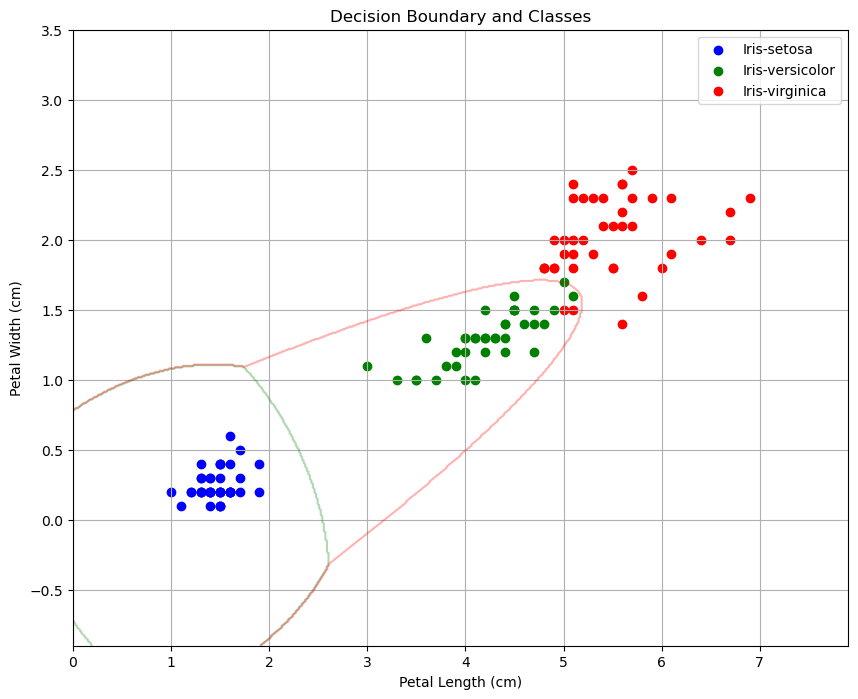

In [75]:
# Load iris dataset
iris_df = pd.read_csv('./iris.csv')

#Only two features
iris_df = iris_df[['PetalLengthCm', 'PetalWidthCm', 'Species']]

# Testing data: First 10 samples of each variety
test_df = []
for class_label in iris_df['Species'].unique():
    sample = iris_df[iris_df['Species'] == class_label].head(10)
    test_df.append(sample)

test_df = pd.concat(test_df)

n = 3
#Dropping testing dataset
training_df = iris_df.drop(test_df.index)

# Mapping species to integers: 'setosa' -> 0, 'versicolor' -> 1, 'virginica' -> 2
species_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
labels = training_df['Species'].map(species_map).values
training_df.drop(columns = [ 'Species'], inplace = True)


class_data = [training_df[labels == i].values for i in range(3)]
prob = [0.33, 0.33, 0.33]

# Classifying the grid points
weights, biases = bayes_classifier(class_data, prob)

x_min = min(np.min(class_data[0][:, 0]), np.min(class_data[1][:, 0]), np.min(class_data[2][:, 0])) - 1
x_max = max(np.max(class_data[0][:, 0]), np.max(class_data[1][:, 0]), np.max(class_data[2][:, 0])) + 1
y_min = min(np.min(class_data[0][:, 1]), np.min(class_data[1][:, 1]), np.min(class_data[2][:, 1])) - 1
y_max =  max(np.max(class_data[0][:, 1]), np.max(class_data[1][:, 1]), np.max(class_data[2][:, 1])) + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Initialize decision boundary array
zz = np.zeros(xx.shape)

# Evaluate the classifier for all grid points
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        point = np.array([xx[i, j], yy[i, j]])
        scores = []
        
        # Calculate scores for each class
        for k in range(len(class_data)):
            if isinstance(weights[k], tuple):  # Non-linear case
                score = point.T @ weights[k][0] @ point + weights[k][1] @ point + biases[k]
            else:  # Linear case
                score = weights[k] @ point + biases[k]
            scores.append(score)
        
        # Assign class based on the maximum score
        zz[i, j] = np.argmax(scores)

# Plotting the contour of the decision boundaries
plt.figure(figsize=(10, 8))
plt.contour(xx, yy, zz, alpha=0.3, colors = ['red', 'green'],  levels=np.arange(-0.5, 3, 1))  # Decision regions

# Plotting the points from each class
colors = ['blue', 'green', 'red']
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
for i, class_d in enumerate(class_data):
    plt.scatter(class_d[:, 0], class_d[:, 1], color=colors[i], label=labels[i])

# Plot details
plt.title('Decision Boundary and Classes')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
# Mapping the test labels to integers for comparison
test_labels = test_df['Species'].map(species_map).values

# Dropping the 'Species' column from the test data, keeping only the features
test_features = test_df.drop(columns=['Species']).values

# Classifying the test data
test_predictions = []
for point in test_features:
    scores = []
    for k in range(len(class_data)):
        if isinstance(weights[k], tuple):
            score = point.T @ weights[k][0] @ point + weights[k][1] @ point + biases[k]
        else:
            score = weights[k] @ point + biases[k]
        scores.append(score)
    test_predictions.append(np.argmax(scores))

# Convert test_predictions to numpy array for easy comparison
test_predictions = np.array(test_predictions)

# Calculating accuracy
accuracy = np.mean(test_predictions == test_labels) * 100
print(f'Accuracy of the Bayes Classifier: {accuracy:.2f}%')


Accuracy of the Bayes Classifier: 100.00%


In [77]:
# Create a mapping for the labels
species_names = {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

# Printing true and predicted labels for each test sample
for i, (true, pred) in enumerate(zip(test_labels, test_predictions)):
    true_label = species_names[true]
    predicted_label = species_names[pred]
    print(f"Sample {i+1}: True label = {true_label}, Predicted = {predicted_label}")


Sample 1: True label = Iris-setosa, Predicted = Iris-setosa
Sample 2: True label = Iris-setosa, Predicted = Iris-setosa
Sample 3: True label = Iris-setosa, Predicted = Iris-setosa
Sample 4: True label = Iris-setosa, Predicted = Iris-setosa
Sample 5: True label = Iris-setosa, Predicted = Iris-setosa
Sample 6: True label = Iris-setosa, Predicted = Iris-setosa
Sample 7: True label = Iris-setosa, Predicted = Iris-setosa
Sample 8: True label = Iris-setosa, Predicted = Iris-setosa
Sample 9: True label = Iris-setosa, Predicted = Iris-setosa
Sample 10: True label = Iris-setosa, Predicted = Iris-setosa
Sample 11: True label = Iris-versicolor, Predicted = Iris-versicolor
Sample 12: True label = Iris-versicolor, Predicted = Iris-versicolor
Sample 13: True label = Iris-versicolor, Predicted = Iris-versicolor
Sample 14: True label = Iris-versicolor, Predicted = Iris-versicolor
Sample 15: True label = Iris-versicolor, Predicted = Iris-versicolor
Sample 16: True label = Iris-versicolor, Predicted = I